In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import matplotlib.pyplot as plt
import torchvision.transforms as tr
import torchvision.datasets as datasets
import torchvision.utils as ut
import numpy as np
import torch.optim as optim
import os
import time
####数据集建立######
%matplotlib inline
nz=100
imagne_size=64
ngf=64
nc=3
epoch_num=5
transform1=tr.Compose([tr.ToTensor(),tr.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=datasets.CIFAR10(root='./data',train=True,transform=transform1,download=True)
real_sets=torch.utils.data.DataLoader(trainset,batch_size=5,shuffle=True,num_workers=2)
classes=['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device=torch.device('cuda:0' if (torch.cuda.is_available())else 'cpu')
def init_parameter(m):
    classname=m.__class__.__name__
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm')!=-1:
        nn.init.normal_(m.weight.data,1.0,0.02)
        nn.init.normal_(m.bias.data,0)

class DCGAN_generator(nn.Module):
    def __init__(self,):
        super().__init__()
        self.main=nn.Sequential(
            nn.ConvTranspose2d(nz,4*ngf,4,1,0),
            nn.BatchNorm2d(4*ngf),
            nn.ReLU(True),####outsize=4*4*(8*ngf)
            nn.ConvTranspose2d(4*ngf,2*ngf,4,2,1),
            nn.BatchNorm2d(2*ngf),
            nn.ReLU(True),####out=8*8*(2*ngf)
            nn.ConvTranspose2d(2*ngf,ngf,4,2,1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),####out=16*16*(ngf)
            nn.ConvTranspose2d(ngf,nc,4,2,1),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),####out=32*32*(nc)
            nn.Tanh()
        )
    def forward(self,x):
        return self.main(x)

class DCGAN_discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main=nn.Sequential(
            nn.Conv2d(nc,ngf,4,2,1),##input=32*32*nc
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.02,inplace=True),##out=16*16*ngf
            nn.Conv2d(ngf,2*ngf,4,2,1),
            nn.BatchNorm2d(2*ngf),
            nn.LeakyReLU(0.02,inplace=True),##out=8*8*(2*ngf)
            nn.Conv2d(2*ngf,4*ngf,4,2,1),
            nn.BatchNorm2d(4*ngf),
            nn.LeakyReLU(0.02,inplace=True),##out=4*4*(4*ngf)
            nn.Conv2d(4*ngf,1,4,1,0),###out=2*2*1
            nn.Sigmoid()
            
        )
    def forward(self,x):
        return self.main(x)
gen=DCGAN_generator().to(device)
dis=DCGAN_discriminator().to(device)
gen.apply(init_parameter)
print(gen)
print(dis)
cirterion=nn.BCELoss()
fixed_noise=torch.rand(64,nz,1,1,device=device)
real_label=1
fake_label=0
optimzer_G=optim.Adam(gen.parameters(),lr=0.0002,betas=(0.5,0.999))
optimzer_D=optim.Adam(dis.parameters(),lr=0.0002,betas=(0.5,0.999))
optimzer_G.zero_grad()
optimzer_D.zero_grad()
G_losses=[]
D_losses=[]
img_list=[]
iters=0
############train##########
#1.traning D with all real
#2.training D with all fake
#3.training G with noise
print('start training...')
for epoch in range(epoch_num):
    for i,real_samples in enumerate(real_sets):
        #print('start training D with all real samples....')
        dis.zero_grad()
        real_samples=real_samples[0].to(device)
        #print(real_samples.size(4))
        b_size=real_samples.size(0)
        samples_label=torch.randn(b_size)
        samples_label=samples_label.fill_(real_label).to(device) ####all label=1
        #print(samples_label.size(),'****************88888size******************')
        out=dis(real_samples).view(-1)
        #print(out.size(),'**********8out************')
        err_real=cirterion(out,samples_label)
        err_real.backward()
        Dx=out.mean().item()###print全是真实数据训练时候的loss mean
        #print('start training D with all fake samples....')
        noise=torch.randn(b_size,nz,1,1,device=device)
        fake_sample=gen(noise)
        out=dis(fake_sample.detach()).view(-1)
        samples_label.fill_(fake_label)#### all label=0 
        err_fake=cirterion(out,samples_label)
        err_fake.backward()
        DG1=out.mean().item()####print fake loos mean
        err_D=err_real+err_fake ###total error
        optimzer_D.step()
        #######training G
        gen.zero_grad()
        out=dis(fake_sample).view(-1)
        samples_label.fill_(real_label)####trainning G ,label=0
        err_G=cirterion(out,samples_label)
        err_G.backward()
        DG2=out.mean().item()
        optimzer_G.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, epoch_num, i, len(real_sets),
                     err_D.item(), err_G.item(), Dx, DG1, DG2))

        # Save Losses for plotting later
        G_losses.append(err_G.item())
        D_losses.append(err_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == epoch_num-1) and (i == len(real_sets)-1)):
            with torch.no_grad():
                fake = gen(noise).detach().cpu()
            img_list.append(ut.make_grid(fake, padding=2, normalize=True))

        iters += 1
def sl_model(path='./model/',mode='save'): ####save and load model
    if mode=='save':
        if not os.path.exists(path):
            os.makedirs(path)
        path=path+str(time.asctime( time.localtime(time.time()) ))
        torch.save(a,path)
        print('model saved in:%s'% path)
    else:
        model=torch.load(path)
        print('load model from:%s'%path)
        return model

sl_model()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()        

    

Files already downloaded and verified
DCGAN_generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Tanh()
  )
)
DCGAN_discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1):

[0/5][3850/10000]	Loss_D: 0.0003	Loss_G: 8.2100	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[0/5][3900/10000]	Loss_D: 0.0002	Loss_G: 8.6215	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][3950/10000]	Loss_D: 0.0002	Loss_G: 8.4436	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][4000/10000]	Loss_D: 0.0007	Loss_G: 7.5021	D(x): 1.0000	D(G(z)): 0.0007 / 0.0006
[0/5][4050/10000]	Loss_D: 0.0004	Loss_G: 8.0331	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[0/5][4100/10000]	Loss_D: 0.0002	Loss_G: 8.7053	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][4150/10000]	Loss_D: 0.0002	Loss_G: 8.8262	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[0/5][4200/10000]	Loss_D: 0.0001	Loss_G: 9.2704	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[0/5][4250/10000]	Loss_D: 0.0001	Loss_G: 9.4164	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[0/5][4300/10000]	Loss_D: 0.0001	Loss_G: 9.4228	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[0/5][4350/10000]	Loss_D: 0.0015	Loss_G: 7.0080	D(x): 1.0000	D(G(z)): 0.0015 / 0.0009
[0/5][4400/10000]	Loss_D: 0.0017	Loss_G: 7.5422	D(x): 

[0/5][8650/10000]	Loss_D: 0.0012	Loss_G: 6.9966	D(x): 1.0000	D(G(z)): 0.0012 / 0.0009
[0/5][8700/10000]	Loss_D: 0.0005	Loss_G: 7.6873	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[0/5][8750/10000]	Loss_D: 0.0002	Loss_G: 8.3671	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][8800/10000]	Loss_D: 0.0001	Loss_G: 8.9456	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[0/5][8850/10000]	Loss_D: 0.0001	Loss_G: 9.0365	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[0/5][8900/10000]	Loss_D: 0.0002	Loss_G: 8.3899	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][8950/10000]	Loss_D: 0.0005	Loss_G: 7.8463	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004
[0/5][9000/10000]	Loss_D: 0.0004	Loss_G: 7.9561	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[0/5][9050/10000]	Loss_D: 0.0002	Loss_G: 8.5034	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][9100/10000]	Loss_D: 0.0003	Loss_G: 8.2077	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[0/5][9150/10000]	Loss_D: 0.0017	Loss_G: 6.8325	D(x): 1.0000	D(G(z)): 0.0016 / 0.0011
[0/5][9200/10000]	Loss_D: 0.0006	Loss_G: 7.6018	D(x): 

[1/5][3450/10000]	Loss_D: 0.0003	Loss_G: 12.3815	D(x): 0.9997	D(G(z)): 0.0000 / 0.0000
[1/5][3500/10000]	Loss_D: 0.0000	Loss_G: 12.4624	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3550/10000]	Loss_D: 0.0000	Loss_G: 12.7431	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3600/10000]	Loss_D: 0.0000	Loss_G: 12.7533	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3650/10000]	Loss_D: 0.0000	Loss_G: 12.9046	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3700/10000]	Loss_D: 0.0000	Loss_G: 12.9428	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3750/10000]	Loss_D: 0.0000	Loss_G: 12.8888	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3800/10000]	Loss_D: 0.0000	Loss_G: 11.9114	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3850/10000]	Loss_D: 0.0003	Loss_G: 8.7238	D(x): 1.0000	D(G(z)): 0.0003 / 0.0002
[1/5][3900/10000]	Loss_D: 0.0000	Loss_G: 10.8339	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][3950/10000]	Loss_D: 0.0000	Loss_G: 11.4233	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][4000/10000]	Loss_D: 0.0000	Loss_G: 11.

[1/5][8200/10000]	Loss_D: 0.0000	Loss_G: 16.0506	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8250/10000]	Loss_D: 0.0000	Loss_G: 16.1176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8300/10000]	Loss_D: 0.0000	Loss_G: 16.1790	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8350/10000]	Loss_D: 0.0000	Loss_G: 16.2417	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8400/10000]	Loss_D: 0.0000	Loss_G: 16.2964	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8450/10000]	Loss_D: 0.0000	Loss_G: 16.3506	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8500/10000]	Loss_D: 0.0000	Loss_G: 16.4046	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8550/10000]	Loss_D: 0.0000	Loss_G: 16.4525	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8600/10000]	Loss_D: 0.0000	Loss_G: 16.4693	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8650/10000]	Loss_D: 0.0000	Loss_G: 16.4930	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8700/10000]	Loss_D: 0.0000	Loss_G: 15.8054	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][8750/10000]	Loss_D: 0.0000	Loss_G: 15

[2/5][2950/10000]	Loss_D: 0.0000	Loss_G: 18.4574	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3000/10000]	Loss_D: 0.0000	Loss_G: 18.4908	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3050/10000]	Loss_D: 0.0000	Loss_G: 18.5231	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3100/10000]	Loss_D: 0.0000	Loss_G: 18.5541	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3150/10000]	Loss_D: 0.0000	Loss_G: 18.5859	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3200/10000]	Loss_D: 0.0000	Loss_G: 18.6171	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3250/10000]	Loss_D: 0.0000	Loss_G: 18.6447	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3300/10000]	Loss_D: 0.0000	Loss_G: 18.6730	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3350/10000]	Loss_D: 0.0000	Loss_G: 18.7047	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3400/10000]	Loss_D: 0.0000	Loss_G: 18.7380	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3450/10000]	Loss_D: 0.0000	Loss_G: 18.7641	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][3500/10000]	Loss_D: 0.0000	Loss_G: 18

[2/5][7700/10000]	Loss_D: 0.0000	Loss_G: 20.5396	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][7750/10000]	Loss_D: 0.0000	Loss_G: 20.5910	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][7800/10000]	Loss_D: 0.0000	Loss_G: 20.6430	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][7850/10000]	Loss_D: 0.0000	Loss_G: 20.6870	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][7900/10000]	Loss_D: 0.0000	Loss_G: 18.1509	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][7950/10000]	Loss_D: 0.0000	Loss_G: 18.1279	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][8000/10000]	Loss_D: 0.0000	Loss_G: 18.8804	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][8050/10000]	Loss_D: 0.0000	Loss_G: 18.9531	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][8100/10000]	Loss_D: 0.0000	Loss_G: 19.2455	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][8150/10000]	Loss_D: 0.0000	Loss_G: 19.5481	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][8200/10000]	Loss_D: 0.0000	Loss_G: 19.7840	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/5][8250/10000]	Loss_D: 0.0000	Loss_G: 19

[3/5][2450/10000]	Loss_D: 0.0000	Loss_G: 32.7230	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][2500/10000]	Loss_D: 0.0000	Loss_G: 32.6251	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][2550/10000]	Loss_D: 0.0000	Loss_G: 32.4002	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][2600/10000]	Loss_D: 0.0000	Loss_G: 32.1294	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][2650/10000]	Loss_D: 0.0000	Loss_G: 31.6090	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][2700/10000]	Loss_D: 0.0000	Loss_G: 27.8113	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][2750/10000]	Loss_D: 0.0009	Loss_G: 7.5405	D(x): 1.0000	D(G(z)): 0.0009 / 0.0005
[3/5][2800/10000]	Loss_D: 0.0002	Loss_G: 11.0813	D(x): 1.0000	D(G(z)): 0.0002 / 0.0000
[3/5][2850/10000]	Loss_D: 0.0004	Loss_G: 8.2565	D(x): 1.0000	D(G(z)): 0.0004 / 0.0003
[3/5][2900/10000]	Loss_D: 0.0002	Loss_G: 8.6086	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[3/5][2950/10000]	Loss_D: 0.0002	Loss_G: 8.9302	D(x): 1.0000	D(G(z)): 0.0002 / 0.0001
[3/5][3000/10000]	Loss_D: 0.0023	Loss_G: 4.8467

[3/5][7200/10000]	Loss_D: 0.0000	Loss_G: 15.8690	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7250/10000]	Loss_D: 0.0000	Loss_G: 15.8863	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7300/10000]	Loss_D: 0.0000	Loss_G: 15.9255	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7350/10000]	Loss_D: 0.0000	Loss_G: 15.9591	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7400/10000]	Loss_D: 0.0000	Loss_G: 15.8953	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7450/10000]	Loss_D: 0.0000	Loss_G: 15.9326	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7500/10000]	Loss_D: 0.0000	Loss_G: 15.9983	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7550/10000]	Loss_D: 0.0000	Loss_G: 16.0078	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7600/10000]	Loss_D: 0.0000	Loss_G: 16.0684	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7650/10000]	Loss_D: 0.0000	Loss_G: 16.0821	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7700/10000]	Loss_D: 0.0000	Loss_G: 16.1025	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/5][7750/10000]	Loss_D: 0.0000	Loss_G: 16

[4/5][1950/10000]	Loss_D: 0.0000	Loss_G: 18.2319	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2000/10000]	Loss_D: 0.0000	Loss_G: 18.2682	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2050/10000]	Loss_D: 0.0000	Loss_G: 18.3043	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2100/10000]	Loss_D: 0.0000	Loss_G: 18.3381	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2150/10000]	Loss_D: 0.0000	Loss_G: 18.3742	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2200/10000]	Loss_D: 0.0000	Loss_G: 18.4115	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2250/10000]	Loss_D: 0.0000	Loss_G: 18.4479	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2300/10000]	Loss_D: 0.0000	Loss_G: 18.4837	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2350/10000]	Loss_D: 0.0000	Loss_G: 18.5139	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2400/10000]	Loss_D: 0.0000	Loss_G: 18.5455	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2450/10000]	Loss_D: 0.0000	Loss_G: 18.5771	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][2500/10000]	Loss_D: 0.0000	Loss_G: 18

[4/5][6700/10000]	Loss_D: 0.0000	Loss_G: 18.5683	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][6750/10000]	Loss_D: 0.0000	Loss_G: 18.8395	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][6800/10000]	Loss_D: 0.0000	Loss_G: 19.0530	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][6850/10000]	Loss_D: 0.0000	Loss_G: 19.2312	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][6900/10000]	Loss_D: 0.0000	Loss_G: 19.3831	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][6950/10000]	Loss_D: 0.0000	Loss_G: 19.5138	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][7000/10000]	Loss_D: 0.0000	Loss_G: 19.6355	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][7050/10000]	Loss_D: 0.0000	Loss_G: 19.7425	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][7100/10000]	Loss_D: 0.0000	Loss_G: 19.8397	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][7150/10000]	Loss_D: 0.0000	Loss_G: 19.9314	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][7200/10000]	Loss_D: 0.0000	Loss_G: 20.0182	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[4/5][7250/10000]	Loss_D: 0.0000	Loss_G: 20

NameError: name 'time' is not defined

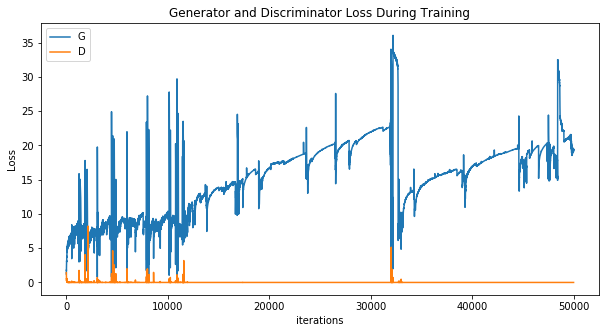

In [28]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()  